In [3]:
%reload_ext autoreload
%autoreload 2

from common_imports import *

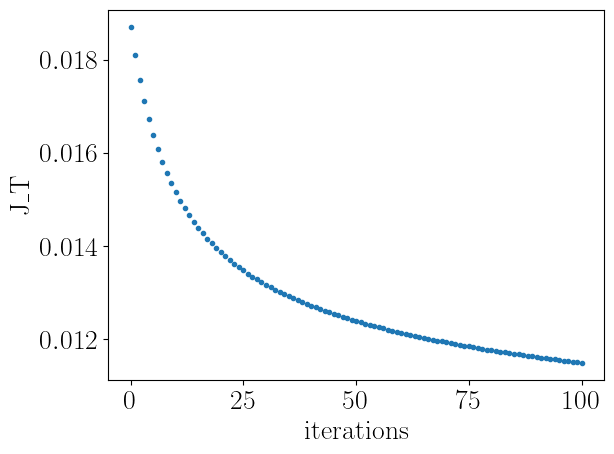

In [4]:
opt_blue = krotov.result.Result().load("data/krotov/notch_blue_continued.pkl")
plt.plot(opt_blue.iters,opt_blue.info_vals,'.')
plt.xlabel("iterations")
plt.ylabel("J_T")
plt.show()

In [66]:
system = Ps_system(N_atoms = 1,N_points = 100)
sequence = laser_sequence()
system.init_distribution_MB()
#system.init_distribution_flattop()
system.init_states_ground()
system.create_composite()


opt_blue = krotov.result.Result().load("data/krotov/archive_desymmetrization/desymmetrization_blue_detuned.pkl")
opt_red = krotov.result.Result().load("data/krotov/archive_desymmetrization/desymmetrization_MB_optimization_30ps_extended_red_detuned.pkl")
#opt_blue = krotov.result.Result().load("data/krotov/notch_blue_continued.pkl")
#opt_red = krotov.result.Result().load("data/krotov/notch_red_continued.pkl")
tlist = opt_red.tlist # tlists are the same for blue and red-detuned pulses
blue_detuning = opt_blue.optimized_controls[0]
blue_envelope = opt_blue.optimized_controls[2]
red_detuning = opt_red.optimized_controls[0]
red_envelope = opt_red.optimized_controls[2]

direction = 1 # in positive direction
blue_kwargs = {
    "envelope":blue_envelope,
    "tlist":tlist
    }
red_kwargs = {
    "envelope":red_envelope,
    "tlist":tlist
    }

red = red_kwargs.copy(); red["unit_wavevector"] = -direction
red_reflected = red_kwargs.copy(); red_reflected["unit_wavevector"] = direction
blue = blue_kwargs.copy(); blue["unit_wavevector"] = -direction
blue_reflected = blue_kwargs.copy(); blue_reflected["unit_wavevector"] = direction

N_cycles = 30
N = tlist.size
for i in range(N_cycles):
    # 6.175GHz corresponds to a detuning of one unit of photon momentum
    red["detuning"] =  red_detuning - np.full(N,i*2*np.pi*(7e-3)+2*2*np.pi*(6.175e-3))
    red_reflected["detuning"] = -red_detuning + np.full(N,i*2*np.pi*(7e-3)+2*2*np.pi*(6.175e-3))
    blue["detuning"] = blue_detuning + np.full(N,i*2*np.pi*(7e-3)+2*2*np.pi*(6.175e-3))
    blue_reflected["detuning"] = -blue_detuning - np.full(N,i*2*np.pi*(7e-3)+2*2*np.pi*(6.175e-3))
    blue["order"] = 4*i; blue["label"] = "blue"+str(i)
    blue_reflected["order"] = 4*i+1;blue_reflected["label"] = "blue_reflected"+str(i)
    red["order"] = 4*i+2;red["label"] = "red"+str(i)
    red_reflected["order"] = 4*i+3; red_reflected["label"] = "red_reflected"+str(i)
    sequence.init_pulse(red)
    sequence.init_pulse(red_reflected)
    sequence.init_pulse(blue)
    sequence.init_pulse(blue_reflected)


In [67]:
sorted_sequence = sequence.pull_sorted_sequence()
opts = qt.Options(store_states=True)
states = system.states
saved = [states]
results = []
#print(sorted_sequence)
for laser in sorted_sequence:
    laser = laser[1]
    system.set_Hamiltonian_MT_general_laser(laser)
    result = qt.sesolve(tlist=laser.tlist,psi0=states,H=system.H,e_ops=system.e_ops,options=opts)
    states = result.states[-1]
    results.append(result)
    saved.append(states)

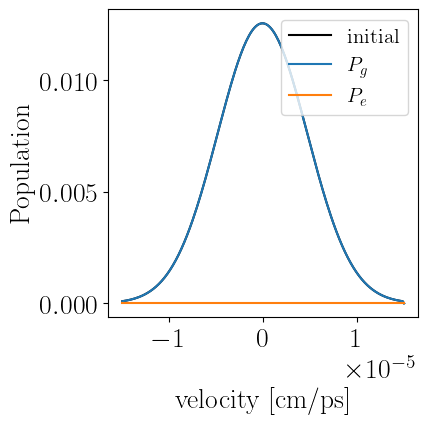

In [68]:

N = system.N_points
fig,ax = plt.subplots(figsize=(4,4))
ax.plot(system.velocity_bins, np.asarray(results[0].expect)[0:N,0]+np.asarray(results[0].expect)[N:N*2,0],label="initial",color="black")
ax.plot(system.velocity_bins, np.asarray(results[0].expect)[0:N,0],label=r"$P_g$")
ax.plot(system.velocity_bins, np.asarray(results[0].expect)[N:2*N,0],label=r"$P_e$")
ax.set_xlabel("velocity [cm/ps]",labelpad=25)
ax.set_ylabel("Population")
ax.legend(fontsize=15)
plt.show()
# fig,ax = plt.subplots(figsize=(4,4))
# ax.plot(system.velocity_bins, np.asarray(results[0].expect)[0:N,0]+np.asarray(results[0].expect)[N:N*2,0],label="initial",color="black")
# ax.plot(system.velocity_bins, np.asarray(results[0].expect)[0:N,-1],label=r"$P_g$")
# ax.plot(system.velocity_bins, np.asarray(results[0].expect)[N:2*N,-1],label=r"$P_e$")
# ax.set_xlabel("velocity [cm/ps]",labelpad=25)
# ax.set_ylabel("Population")
# ax.legend(fontsize=15)
# plt.show()
fig,ax = plt.subplots(figsize=(4,4))
ax.plot(system.velocity_bins, np.asarray(results[0].expect)[0:N,0]+np.asarray(results[0].expect)[N:N*2,0],label="initial",color="black")
ax.plot(system.velocity_bins, np.asarray(results[-1].expect)[0:N,-1],label=r"$P_g$")
ax.plot(system.velocity_bins, np.asarray(results[-1].expect)[N:2*N,-1],label=r"$P_e$")
ax.set_xlabel("velocity [cm/ps]",labelpad=25)
ax.set_ylabel("Population")
ax.legend(fontsize=15)
plt.show()

minimum: 22.86 after 49 pulses


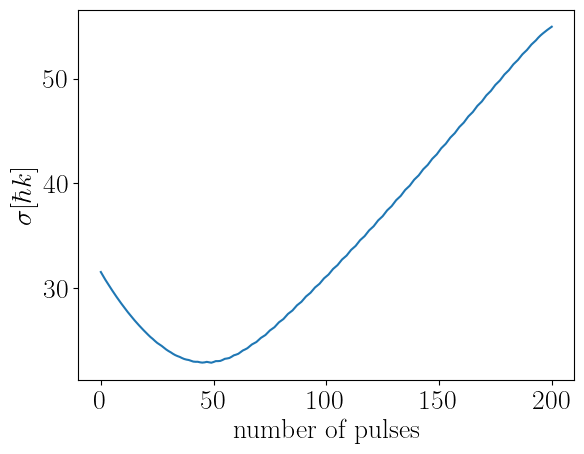

In [69]:
handler = data_handler()
stds = []
for state in saved:
    stds.append(handler.expect_standard_deviation(state,system.N_points))
plt.plot(np.arange(len(stds)),stds)
plt.ylabel(r"$\sigma [\hbar k]$")
plt.xlabel("number of pulses")
print("minimum: {:.2f} after {} pulses".format(np.amin(stds),np.argmin(stds)))

In [19]:
ground_population = []
excited_population = []
for result in results:
    ground_population.append(np.asarray(result.expect)[0:N,-1])
    excited_population.append(np.asarray(result.expect)[N:N*2,-1])

#plt.imshow(np.asarray(ground_population).T)
plt.imshow(np.asarray(excited_population).T)
plt.ylabel("bin")
plt.xlabel("pulse number")
plt.colorbar()